# 11.3 Attention Scoring Functions

It turns out, distance functions are slightly more expensive to compute than dot products. As such, with the softmax operation to ensure nonnegative attention weights, much of the work has gone into attention scoring functions $a$.

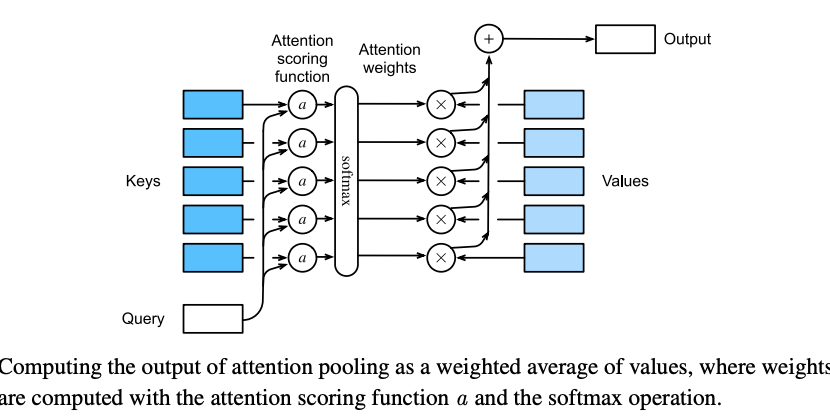

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 11.3.1 Dot Product Attention

Let's review the attention function from the Gaussian kernel for a moment. 

$$
\mathbf{\alpha}(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^T \mathbf{k}_i - \cfrac{1}{2} ||\mathbf{k}_i||^2 -  \cfrac{1}{2} ||\mathbf{q}||^2
$$

Since two norms can be disregarded (because of normalizing attention weight and layer normalization), we drop them from the definition, thus obtain dot product.

Furthermore, to ensure that the variance of the dot product still remains 1 regardless of the vector length, we use the scaled dot product attention scoring function. That is,

$$
\mathbf{\alpha} = \mathbf{q}^T \mathbf{k}_i / \sqrt{d}
$$

And then, we take softmax over all $\alpha$ s .

### 11.3.2 Convenience Functions

We need a few functions to make the attention mechanism efficient to deploy. This includes tools for dealing with strings of variable lengths and tools for efficient evaluation on minimatches.

In some cases, such sequences may end up in the same minibatch, necessitating padding with dummy tokens for shorter sequences (see Section 10.5 for an example). Since we do not want blanks in our attention model we simply need to limit ∑n i=1 α(q, ki)vi to ∑l i=1 α(q, ki)vi for however long, l ≤ n, the actual sentence is. Since it is such a common problem, it has a name: the masked softmax operation

In [3]:
def masked_softmax(X, valid_lens): #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
        device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X
    
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
            
    # On the last axis, replace masked elements with a very large negative
    # value, whose exponentiation outputs 0
    X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4176, 0.5824, 0.0000, 0.0000],
         [0.5707, 0.4293, 0.0000, 0.0000]],

        [[0.2298, 0.3678, 0.4024, 0.0000],
         [0.2667, 0.3658, 0.3675, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2674, 0.3022, 0.4304, 0.0000]],

        [[0.3976, 0.6024, 0.0000, 0.0000],
         [0.2582, 0.3373, 0.2036, 0.2010]]])

### Batch Matrix Multiplication

Assume that

$$
\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, ..., \mathbf{Q}_n] \in \mathbb{R}^{n \times a \times b} \\
\mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, ..., \mathbf{K}_n] \in \mathbb{R}^{n \times b \times c}
$$

Then the batch mm computes the elementwise product

$$
BMM(\mathbf{Q},\mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, ..., \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}
$$

In [6]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

## 11.3.3 Scaled Dot Product Attention

Our minibatch-aware calculation can be written as (all are row vectors):

$$
softmax(\cfrac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d}}) \mathbf{V} \in \mathbb{R}^{n \times v}
$$

In [7]:
class DotProductAttention(nn.Module): #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [8]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

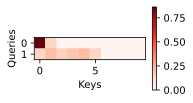

In [9]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
xlabel='Keys', ylabel='Queries')